Some of the models in Darts can produce probabilistic forecasts. For these models, the TimeSeries returned by predict() will be probabilistic, and contain a certain number of Monte Carlo samples describing the joint distribution over time and components. The number of samples can be directly determined by the argument num_samples of the predict() function (leaving num_samples=1 will return a deterministic TimeSeries)

A Monte Carlo simulation is used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



**Importing all the necessory libraries and RNN model**
---

``

Variable noise series
As a toy example we create a target time series that is created by taking the some of a sine wave and a gaussian noise series. To make things interesting, the intensity of the gaussian noise is also modulated by a sine wave (with a different frequency). This means that the effect of the noise gets stronger and weaker in an oscillating fashion. The idea is to test whether a probabilistic RNN can model this oscillating uncertainty in its predictions.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg

from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Support for Covariates- Past covariates are covariate time series whose values are not known into the future at prediction time. Those can for instance represent signals that have to be measured and are not known upfront. Models do not use the future values of past_covariates when making forecasts.

Future covariates are covariate time series whose values are known into the future at prediction time (up until the forecast horizon). These can represent signals such as calendar information, holidays, weather forecasts, etc. Models that accept future_covariates will consume the future values (up to the forecast horizon) when making forecasts.


In [ ]:
data = pd.read_csv("AirPassengers.csv")
data.head()


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (
    tg.sine_timeseries(length=length, value_frequency=0.02)
    + tg.constant_timeseries(length=length, value=1)
) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

Support for multivariate series- Some models support multivariate time series. This means that the target (and potential covariates) series provided to the model during fit and predict stage can have multiple dimensions. The model will then in turn produce multivariate forecasts.

length is a major component as time series derives usefulness from it's length.  This is generally because the greater the number of observations (larger sample size), the more confident one can be in the statistical outputs.

Tg.liear_timeseries - This command is used to construct a TimeSeries object in which the load factor applied is linearly proportional to the time in the domain


In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

oise simply refers to random fluctuations in the time series about its typical pattern.





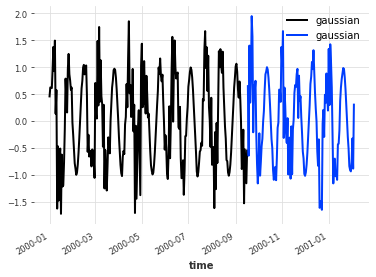

In [ ]:
target_train.plot()
target_val.plot()

In the following we train a probabilistic RNN to predict the targets series in an autoregressive fashion, but also by taking into consideration the modulation of the noise component as a covariate which is known in the future. So the RNN has information on when the noise component of the target is severe, but it doesn’t know the noise component itself. Let’s see if the RNN can make use of this information.

Target variable whose values are to be modeled and forecast.

Train values are those which are used to train our model to forcast our target

In [ ]:
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=50,
    input_chunk_length=20,
    likelihood=GaussianLikelihood(),
)

my_model.fit(target_train, future_covariates=covariates, verbose=True)

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

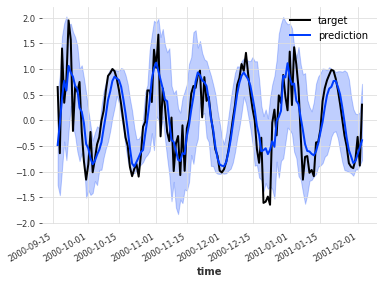

In [ ]:
pred = my_model.predict(140, num_samples=50)
target_val.slice_intersect(pred).plot(label="target")
pred.plot(label="prediction")

We can see that, on top of correctly predicting the, granted, simple oscillatory behavior of the target, the RNN correctly expresses more uncertainty in its predictions when the noise component is higher.


In [ ]:
def plot_predictions(test, predicted, title, x):
    plt.figure(figsize=(16,4))
    plt.plot(x ,test, color='blue',label='Actual')
    plt.plot(x ,predicted, alpha=0.7, color='red',label='Predict')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Passengers')
    plt.legend()
    plt.show()

In [ ]:
plot_predictions(target_train, pred, "LSTM", data.index[-9:])

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2 = r2_score(target_train, pred)

print(r2)

R2 Score   :    0.8925457155458748